In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_image_tensor(path):
    """
    Load image and convert to min-max normalized torch tensor with gradients enabled.
    Returns tensor of shape (H, W) with values in [0, 1].
    """
    # Load with matplotlib to ensure consistent color handling
    image = plt.imread(path)
    image_tensor = torch.from_numpy(image).float()
    
    # Handle different image formats
    if len(image_tensor.shape) == 2:  # Grayscale
        image_tensor = image_tensor.unsqueeze(0).repeat(3, 1, 1)
    elif len(image_tensor.shape) == 3:
        if image_tensor.shape[2] == 4:  # RGBA
            image_tensor = image_tensor[:, :, :3]
        image_tensor = image_tensor.permute(2, 0, 1)
    
    # Normalize if needed
    if image_tensor.max() > 1.0:
        image_tensor = image_tensor / 255.0

    # Convert to grayscale
    grayscale_tensor = torch.einsum('chw,c->hw', image_tensor.detach(), 
                                     torch.tensor([0.299, 0.587, 0.114], device=image_tensor.device))
    
    # Min-max normalization
    min_val, max_val = grayscale_tensor.min(), grayscale_tensor.max()
    if max_val > min_val:  # Avoid division by zero
        grayscale_tensor = (grayscale_tensor - min_val) / (max_val - min_val)
    
    grayscale_tensor.requires_grad_(True)
    return grayscale_tensor

image_tensor = load_image_tensor('/Users/michaelbertagna/git/Galaxy-Deconv/tutorials/example_snr300.png')
print(torch.max(image_tensor))

tensor(1., grad_fn=<MaxBackward1>)


/Users/michaelbertagna/git/Galaxy-Deconv/Galaxy-Deconv.env/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


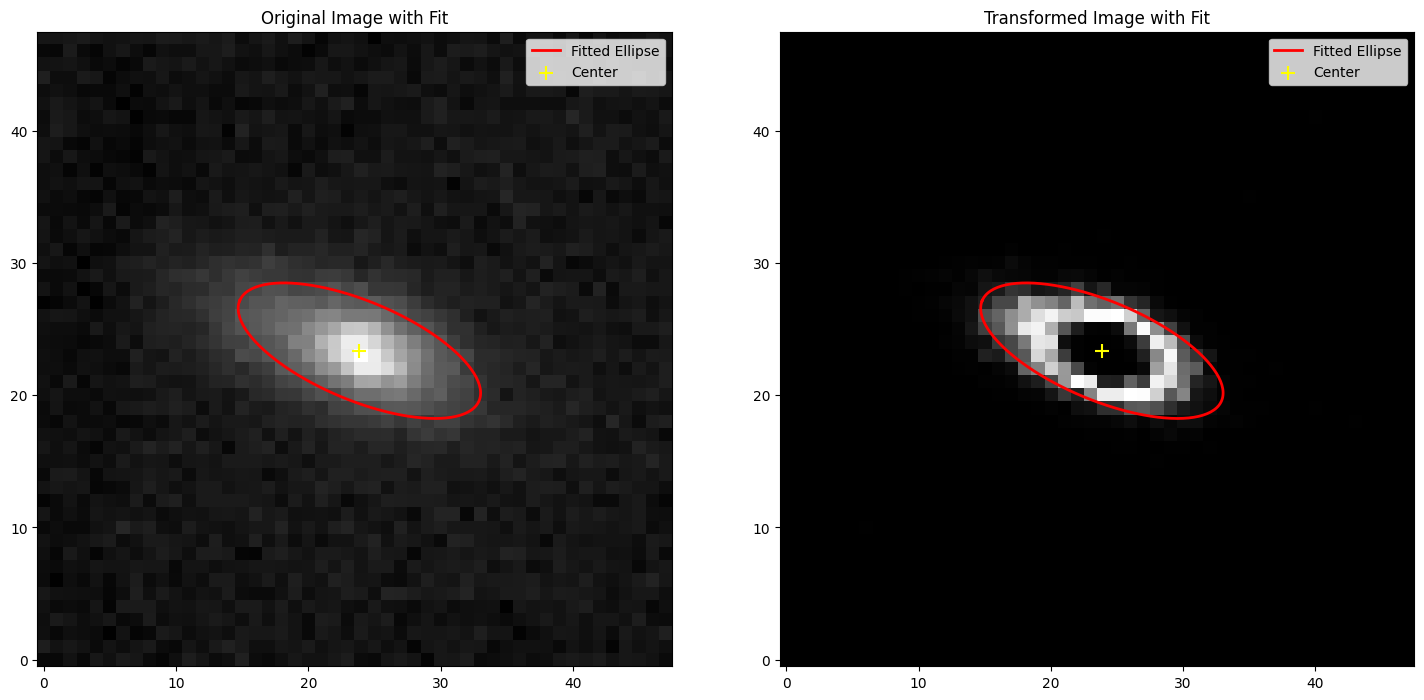

In [ ]:
def transform_tensor(tensor):
    """
    Transform a loaded tensor to match the format of the function that loads PNGs.
    Ensures shape (H, W) with values in [0, 1] and gradients enabled.
    """
    if tensor.dim() == 2:  # Already grayscale
        transformed_tensor = tensor.clone()
    elif tensor.dim() == 3 and tensor.shape[0] in {1, 3}:  # Convert to single channel
        transformed_tensor = tensor.mean(dim=0)  # Convert to grayscale
    
    # Normalize if needed
    if transformed_tensor.max() > 1.0:
        transformed_tensor = transformed_tensor / 255.0

    # Min-max normalization
    min_val, max_val = transformed_tensor.min(), transformed_tensor.max()
    if max_val > min_val:  # Avoid division by zero
        transformed_tensor = (transformed_tensor - min_val) / (max_val - min_val)
    
    transformed_tensor.requires_grad_(True)
    return transformed_tensor

def sigmoid_mask(x: torch.Tensor, 
                   peak_pos: float = 0.4, 
                   sharpness: float = 20.0) -> torch.Tensor:
    """
    Differentiable nonlinear transformation for galaxy edge processing.
    Maintains low values, amplifies mid-range, suppresses highs.
    """
    scaled_x = sharpness * (x - peak_pos)
    return x * torch.sigmoid(scaled_x) * (1 - torch.sigmoid(scaled_x - 2.0))

def mask_to_points_and_weights_full(mask):
    """
    Converts a masked image tensor into points with associated weights.
    """
    H, W = mask.shape
    x_coords, y_coords = torch.meshgrid(torch.arange(H), torch.arange(W))
    points = torch.stack((x_coords.flatten(), y_coords.flatten()), dim=1).float()
    weights = mask.flatten()
    return points, weights

def weighted_ellipse_fit(points, weights):
    """
    Fit an ellipse to weighted points using SVD, avoiding in-place operations.
    
    Parameters:
        points (Tensor): Nx2 tensor of (x, y) points
        weights (Tensor): N-element tensor of weights
    
    Returns:
        params (Tensor): The ellipse parameters [A, B, C, D, E, F]
    """
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Construct the design matrix
    D = torch.stack((x**2, x*y, y**2, x, y, torch.ones_like(x)), dim=1)
    
    # Create diagonal weight matrix and apply weights
    W = torch.diag_embed(weights)
    D_weighted = torch.matmul(W, D)
    
    # Solve using SVD
    U, S, V = torch.svd(D_weighted)
    params = V[:, -1]
    
    # Normalize parameters WITHOUT in-place operation
    norm = torch.norm(params)
    params = params / (norm + 1e-8)  # Add small epsilon for numerical stability
    
    return params

def plot_galaxy_ellipse(image: torch.Tensor, params: torch.Tensor, ax=None):
    """
    Plot the galaxy image with fitted ellipse overlay.
    
    Parameters:
        image (torch.Tensor): Original galaxy image
        params (torch.Tensor): Fitted ellipse parameters [A, B, C, D, E, F]
        ax (matplotlib.axes.Axes, optional): The axes to plot on
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the galaxy image
    ax.imshow(image.cpu().detach().numpy(), cmap='gray', origin='lower')
    
    # Convert parameters to tensors
    A, B, C, D, E, F = [torch.tensor(x) for x in params.tolist()]
    
    # Calculate ellipse center
    denominator = 4*A*C - B**2
    cx = (B*E - 2*C*D) / denominator
    cy = (B*D - 2*A*E) / denominator
    
    # Calculate rotation angle and semi-axes
    theta = 0.5 * torch.atan2(B, A - C)
    cos_t = torch.cos(theta)
    sin_t = torch.sin(theta)
    
    # Calculate semi-axes lengths
    a_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*cos_t**2 + B*cos_t*sin_t + C*sin_t**2)
    b_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*sin_t**2 - B*cos_t*sin_t + C*cos_t**2)
    
    a = torch.sqrt(torch.abs(a_squared))
    b = torch.sqrt(torch.abs(b_squared))
    
    # Generate ellipse points
    t = torch.linspace(0, 2*np.pi, 200)
    x_circle = a * torch.cos(t)
    y_circle = b * torch.sin(t)
    
    # Rotate and translate
    R = torch.tensor([[cos_t, -sin_t],
                     [sin_t, cos_t]])
    points = torch.stack([x_circle, y_circle])
    rotated_points = R @ points
    x = rotated_points[0] + cx
    y = rotated_points[1] + cy
    
    # Plot ellipse overlay
    ax.plot(y.numpy(), x.numpy(), 'r-', label='Fitted Ellipse', linewidth=2)
    ax.scatter(cy.item(), cx.item(), color='yellow', marker='+', s=100, label='Center')
    
    # Customize plot
    ax.set_title('Galaxy Image with Fitted Ellipse')
    ax.legend()
    return ax

def ellipse_params(image_tensor):
    masked_image = sigmoid_mask(image_tensor)
    points, weights = mask_to_points_and_weights_full(masked_image)
    params = weighted_ellipse_fit(points, weights)

    # Assuming params are already tensors, if not, convert them in a differentiable manner
    A, B, C, D, E, F = [param.to(image_tensor.device) for param in params]

    # Calculate ellipse center
    denominator = 4*A*C - B**2
    cx = (B*E - 2*C*D) / denominator
    cy = (B*D - 2*A*E) / denominator
    
    # Calculate rotation angle and semi-axes
    theta = 0.5 * torch.atan2(B, A - C)
    cos_t = torch.cos(theta)
    sin_t = torch.sin(theta)
    
    # Calculate semi-axes lengths
    a_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*cos_t**2 + B*cos_t*sin_t + C*sin_t**2)
    b_squared = -2 * (A*cx**2 + C*cy**2 + B*cx*cy + D*cx + E*cy + F) / \
                (A*sin_t**2 - B*cos_t*sin_t + C*cos_t**2)
    
    a = torch.sqrt(torch.abs(a_squared))
    b = torch.sqrt(torch.abs(b_squared))

    return torch.stack([cx, cy, theta, a, b])

import torch.nn.functional as F

def ellipse_loss(output_params, target_params, center_weight=1.0, angle_weight=1.0, axis_weight=1.0):
    """
    Computes normalized loss between output and target ellipse parameters where each
    component (center, angle, axes) contributes equally to the total loss.
    
    Args:
    - output_params: (cx_out, cy_out, theta_out, a_out, b_out)
    - target_params: (cx_tgt, cy_tgt, theta_tgt, a_tgt, b_tgt)
    - center_weight: Weight for center loss
    - angle_weight: Weight for angle loss
    - axis_weight: Weight for axis loss
    
    Returns:
    - total_loss: Combined normalized loss
    """
    # Unpack parameters
    cx_out, cy_out, theta_out, a_out, b_out = output_params
    cx_tgt, cy_tgt, theta_tgt, a_tgt, b_tgt = target_params
    
    # Center loss (normalized by image size)
    center_coords_out = torch.stack([cx_out, cy_out])
    center_coords_tgt = torch.stack([cx_tgt, cy_tgt])
    
    # Normalize center coordinates by the maximum of target axes
    coord_scale = torch.max(torch.stack([a_tgt, b_tgt]))
    normalized_center_loss = F.mse_loss(
        center_coords_out / (coord_scale + 1e-8),
        center_coords_tgt / (coord_scale + 1e-8)
    )
    
    # Angle loss (normalized to be between 0 and 1)
    # Convert angles to normalized direction vectors to handle periodicity
    def angle_to_vector(theta):
        return torch.stack([torch.cos(theta), torch.sin(theta)])
    
    angle_vec_out = angle_to_vector(theta_out)
    angle_vec_tgt = angle_to_vector(theta_tgt)
    normalized_angle_loss = 0.5 * F.mse_loss(angle_vec_out, angle_vec_tgt)
    
    # Axis loss (normalized by the larger target axis)
    axis_scale = torch.max(torch.stack([a_tgt, b_tgt]))
    normalized_axis_loss = 0.5 * (
        F.l1_loss(a_out / (axis_scale + 1e-8), a_tgt / (axis_scale + 1e-8)) +
        F.l1_loss(b_out / (axis_scale + 1e-8), b_tgt / (axis_scale + 1e-8))
    )
    
    # Combine losses with weights
    total_loss = (
        center_weight * normalized_center_loss +
        angle_weight * normalized_angle_loss +
        axis_weight * normalized_axis_loss
    )

    return total_loss

def process_and_fit_galaxy(image: torch.Tensor, peak_pos = 0.4,  sharpness = 20.0):
    """
    Complete pipeline for processing a galaxy image and fitting an ellipse.
    
    Parameters:
        image (torch.Tensor): Input galaxy image tensor
        
    Returns:
        params (torch.Tensor): Fitted ellipse parameters
        fig (matplotlib.figure.Figure): Figure with the result
    """
    # Apply value transform to enhance edges
    transformed = sigmoid_mask(image,
                               peak_pos = peak_pos, 
                               sharpness = sharpness
                               )
    
    # Convert to points and weights
    points, weights = mask_to_points_and_weights_full(transformed)
    
    # Fit ellipse
    params = weighted_ellipse_fit(points, weights)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image with fit
    plot_galaxy_ellipse(image, params, ax1)
    ax1.set_title('Original Image with Fit')
    
    # Transformed image with fit
    plot_galaxy_ellipse(transformed, params, ax2)
    ax2.set_title('Transformed Image with Fit')
    
    plt.tight_layout()
    return params, fig

galaxy_image = image_tensor

# Example usage:
# Assuming 'galaxy_image' is your input tensor:
params, fig = process_and_fit_galaxy(galaxy_image)
plt.show()

tensor(1., grad_fn=<MaxBackward1>) tensor(1., grad_fn=<MaxBackward1>)


/var/folders/3z/xzj6jd1x4d9cy2w36g2v23b00000gn/T/ipykernel_64722/1439353808.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gt = transform_tensor(torch.load("gt.pth"))


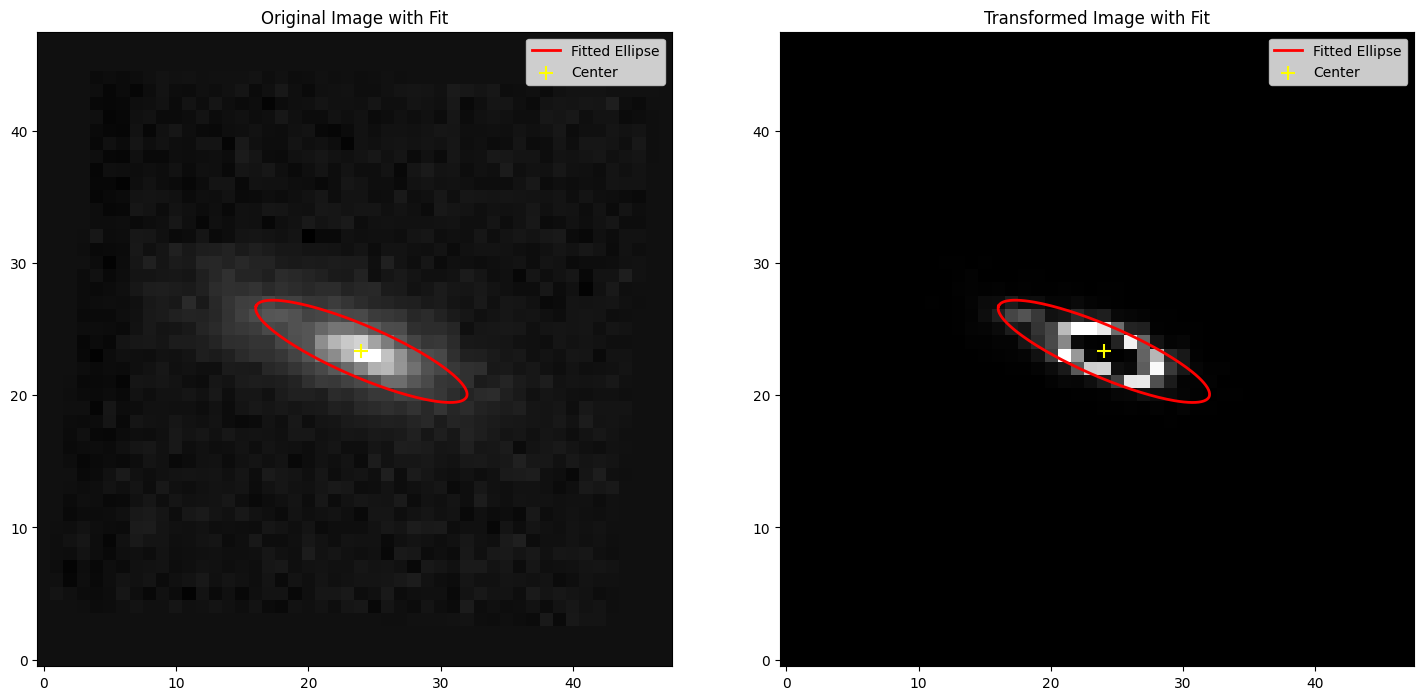

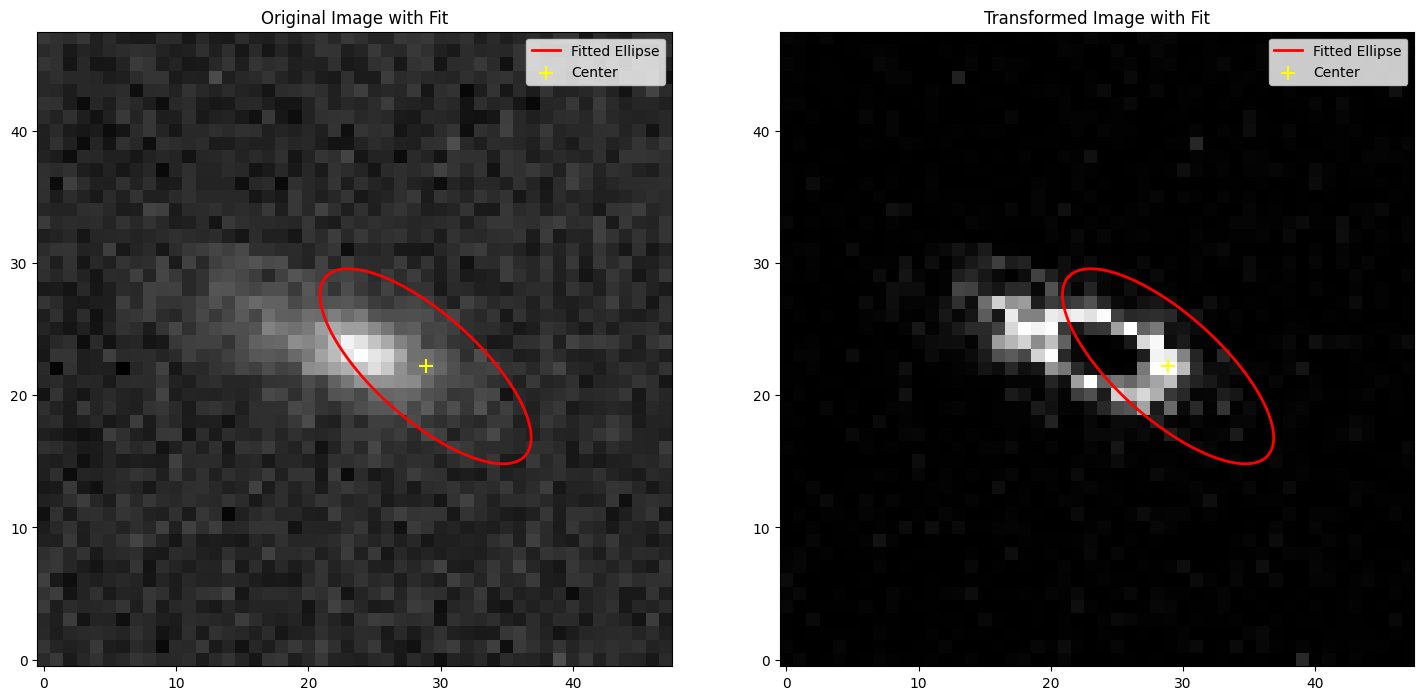

In [ ]:
gt = transform_tensor(torch.load("gt.pth"))
obs = transform_tensor(torch.load("obs.pth"))

print(torch.max(gt), torch.max(obs))

peak_pos_s = np.arange(start=0.1, stop=0.8, step=0.1)
sharpness_s = np.arange(start=1, stop=21, step=1)

for peak_pos in peak_pos_s:
    for sharpness in sharpness_s:
        params, fig = process_and_fit_galaxy(gt, 
                                            #  peak_pos=peak_pos, 
                                            #  sharpness=sharpness
                                             )
        plt.show()
        params, fig = process_and_fit_galaxy(obs,
                                            #  peak_pos=peak_pos, 
                                            #  sharpness=sharpness
                                             )
        plt.show()
        break
    break

In [5]:
x = gt
x.requires_grad_(True)
y1 = ellipse_params(x)
print(y1)
y1.sum().backward()

print(x.shape, x.grad.shape)
print(x.grad)

x = obs
x.requires_grad_(True)
y2 = ellipse_params(x)
print(y2)
y2.sum().backward()

print(x.shape, x.grad.shape)
print(x.grad)

print(ellipse_loss(y1, y2))
print(ellipse_loss(y1, y1))
print(ellipse_loss(y2, y2))

tensor([23.3239, 24.0111, -1.1635,  8.6699,  1.9395], grad_fn=<StackBackward0>)
torch.Size([48, 48]) torch.Size([48, 48])
tensor([[ 0.0005, -0.0019, -0.0034,  ...,  0.0968,  0.0979,  0.0990],
        [ 0.0017, -0.0007, -0.0024,  ...,  0.0818,  0.0827,  0.0837],
        [ 0.0036,  0.0009, -0.0012,  ...,  0.0687,  0.0698,  0.0710],
        ...,
        [ 0.0738,  0.0729,  0.0724,  ...,  0.0201,  0.0231,  0.0264],
        [ 0.0878,  0.0869,  0.0860,  ...,  0.0210,  0.0239,  0.0272],
        [ 0.1033,  0.1025,  0.1008,  ...,  0.0226,  0.0250,  0.0280]])
tensor([22.1925, 28.8680, -0.8398, 10.1269,  3.9649], grad_fn=<StackBackward0>)
torch.Size([48, 48]) torch.Size([48, 48])
tensor([[-4.3633e-04, -7.8889e-01, -3.8377e-03,  ...,  2.8189e-02,
          2.6554e-03,  1.3133e-01],
        [ 2.1055e-01, -5.5220e-03, -1.1304e-02,  ...,  2.6222e-01,
          2.1818e-02,  4.9800e-02],
        [ 4.2688e-02,  9.3016e-04, -1.3844e-02,  ...,  2.6706e-02,
          1.5991e-01,  1.0021e-02],
        ...,


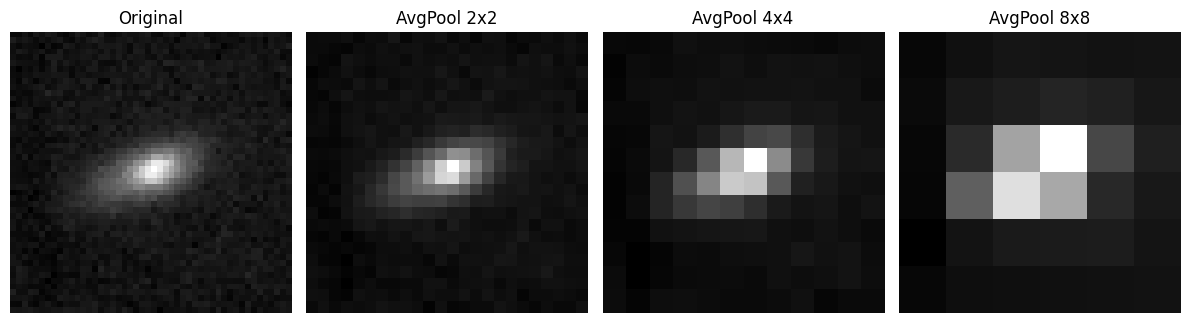

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Function to apply AvgPool2d at different scales and plot results
def plot_avg_pooled_images(image, scales=[2, 4, 8]):
    fig, axes = plt.subplots(1, len(scales) + 1, figsize=(12, 4))

    # Original image (assumed grayscale)
    image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims (1,1,H,W)
    
    # Plot original image
    axes[0].imshow(image.squeeze(0).squeeze(0).cpu().detach().numpy(), cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    scaled_images = {}

    # Apply pooling at different scales
    for i, scale in enumerate(scales):
        avg_pool = nn.AvgPool2d(scale, scale)  # Pooling layer
        pooled_image = avg_pool(image).squeeze(0).squeeze(0)  # Apply pooling

        scaled_images[scale] = pooled_image
        
        # Plot pooled image
        axes[i + 1].imshow(pooled_image.cpu().detach().numpy(), cmap='gray')
        axes[i + 1].set_title(f"AvgPool {scale}x{scale}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    return scaled_images

# Call the function to visualize AvgPool2d results
scaled_images = plot_avg_pooled_images(galaxy_image)

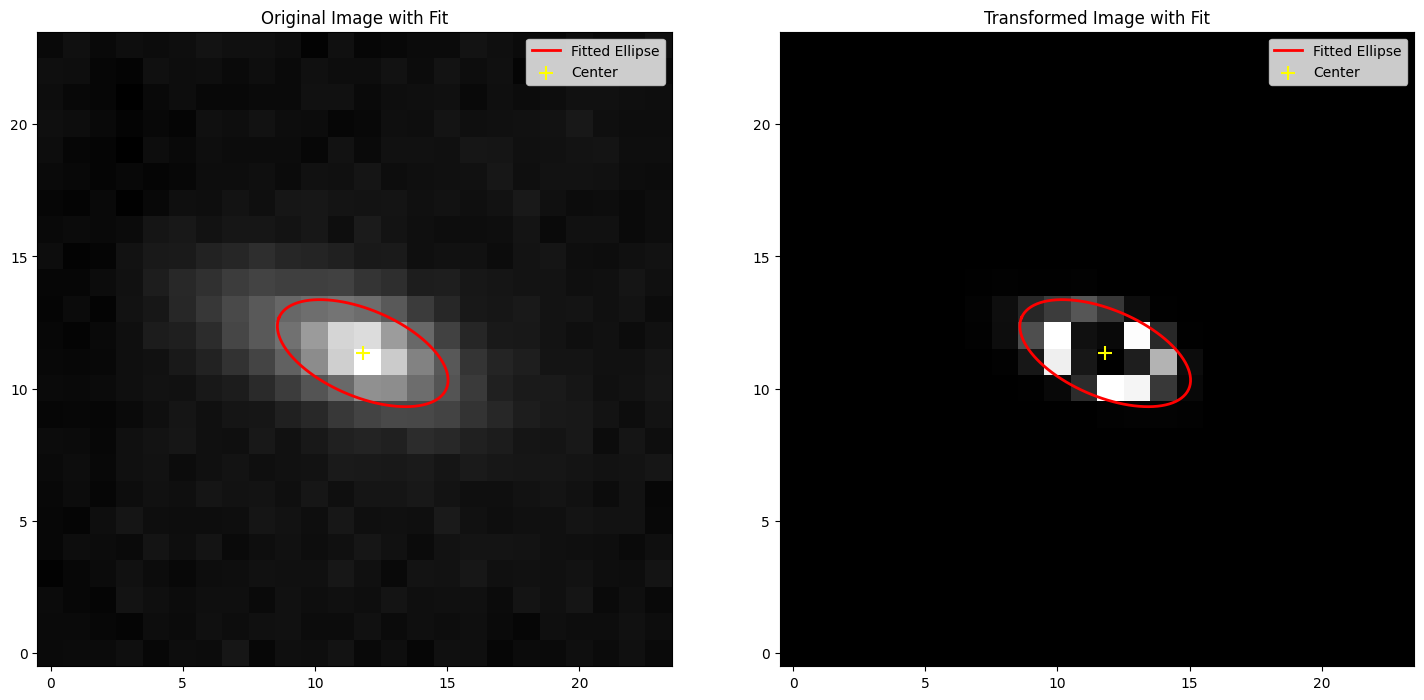

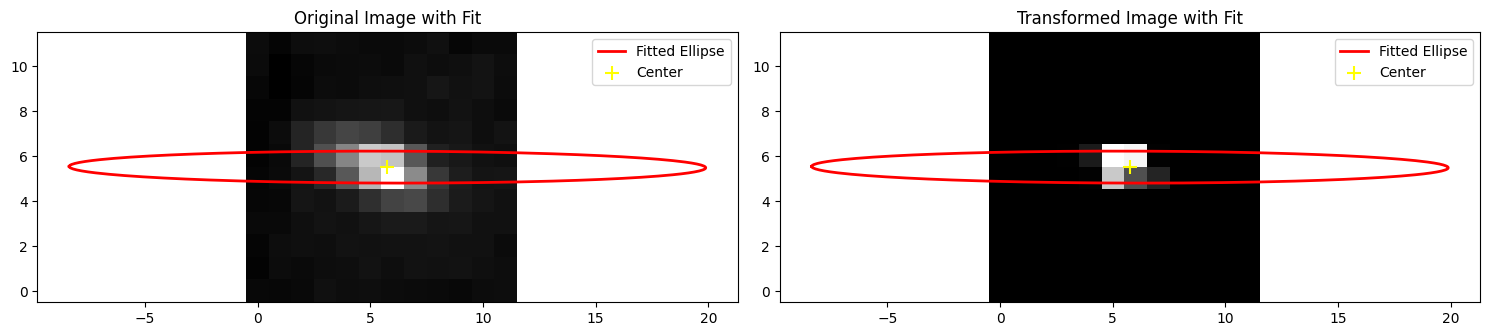

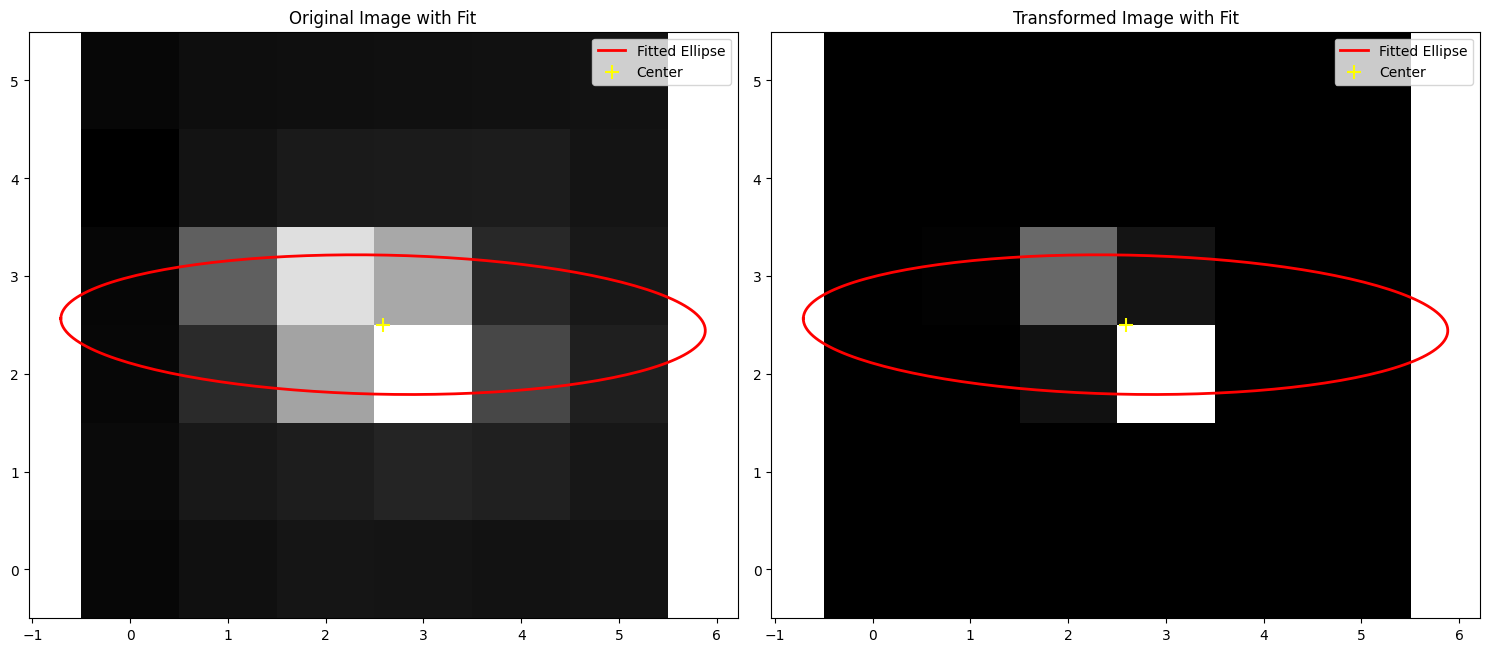

In [7]:
for scale, img in scaled_images.items():
    params, fig = process_and_fit_galaxy(img, peak_pos=0.5, sharpness=20)
    plt.show()